In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-02-06 13:28:50--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2022-02-06 13:28:50 (5.87 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



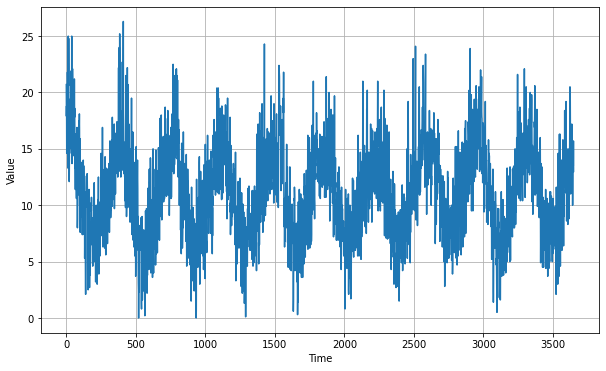

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  t = 0
  for sample in reader:
    temps.append(float(sample[1]))
    time_step.append(t)
    t+=1

# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


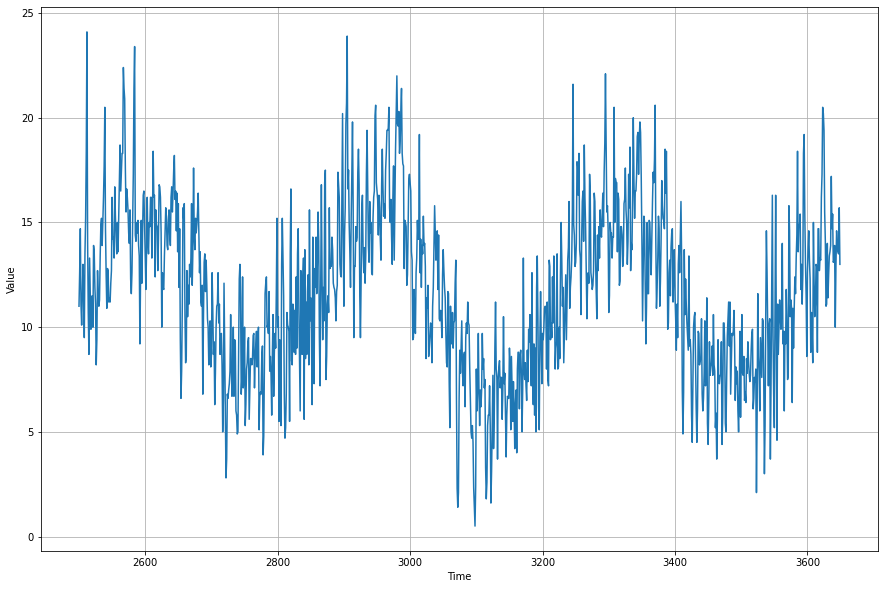

In [ ]:
plt.figure(figsize=(15, 10))
plot_series(time_valid, x_valid)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(30, 5, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.Conv1D(60, 5, padding='causal', activation='relu'),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(10),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 14s 70ms/step - loss: 14.8918 - mae: 15.3918 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 50ms/step - loss: 14.8680 - mae: 15.3680 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 50ms/step - loss: 14.8315 - mae: 15.3315 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 55ms/step - loss: 14.7871 - mae: 15.2871 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 57ms/step - loss: 14.7359 - mae: 15.2359 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 55ms/step - loss: 14.6776 - mae: 15.1776 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 1s 56ms/step - loss: 14.6118 - mae: 15.1118 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 1s 53ms/step - loss: 14.5373 - mae: 15.0373 - lr: 2.

(1e-08, 0.0001, 0.0, 60.0)

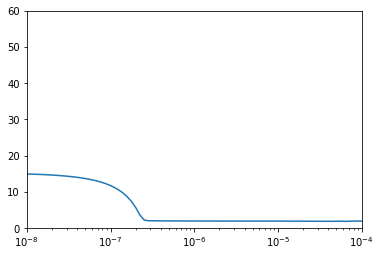

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
loss_list = history.history['loss']
least_loss = min(loss_list)
least_loss_index = loss_list.index(least_loss)
print(least_loss, least_loss_index)

1.7855679988861084 87


In [ ]:
best_lr = history.history['lr'][least_loss_index]

### Trial 1

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(30, 5, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.Conv1D(60, 5, padding='causal', activation='relu'),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(10),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x* 100)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
25/25 [==============================] - 5s 34ms/step - loss: 1.8153 - mae: 2.2660
Epoch 2/30
25/25 [==============================] - 1s 34ms/step - loss: 1.7925 - mae: 2.2447
Epoch 3/30
25/25 [==============================] - 1s 34ms/step - loss: 1.8861 - mae: 2.3400
Epoch 4/30
25/25 [==============================] - 1s 36ms/step - loss: 1.8461 - mae: 2.3022
Epoch 5/30
25/25 [==============================] - 1s 34ms/step - loss: 1.8464 - mae: 2.3052
Epoch 6/30
25/25 [==============================] - 1s 34ms/step - loss: 1.9259 - mae: 2.3836
Epoch 7/30
25/25 [==============================] - 1s 34ms/step - loss: 1.7553 - mae: 2.2076
Epoch 8/30
25/25 [==============================] - 1s 36ms/step - loss: 1.7143 - mae: 2.1631
Epoch 9/30
25/25 [==============================] - 1s 34ms/step - loss: 1.7619 - mae: 2.2109
Epoch 10/30
25/25 [==============================] - 1s 35ms/step - loss: 1.7749 - mae: 2.2262
Epoch 11/30
25/25 [==============================] - 1s 35m

Trial 2

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(30, 5, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.Conv1D(60, 5, padding='causal', activation='relu'),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x* 100)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
25/25 [==============================] - 5s 33ms/step - loss: 1.5633 - mae: 2.0068
Epoch 2/30
25/25 [==============================] - 1s 34ms/step - loss: 1.5513 - mae: 1.9910
Epoch 3/30
25/25 [==============================] - 1s 34ms/step - loss: 1.6740 - mae: 2.1232
Epoch 4/30
25/25 [==============================] - 1s 34ms/step - loss: 1.5822 - mae: 2.0292
Epoch 5/30
25/25 [==============================] - 1s 34ms/step - loss: 1.7206 - mae: 2.1694
Epoch 6/30
25/25 [==============================] - 1s 35ms/step - loss: 1.6535 - mae: 2.1054
Epoch 7/30
25/25 [==============================] - 1s 34ms/step - loss: 1.5567 - mae: 1.9997
Epoch 8/30
25/25 [==============================] - 1s 35ms/step - loss: 1.5487 - mae: 1.9940
Epoch 9/30
25/25 [==============================] - 1s 34ms/step - loss: 1.6435 - mae: 2.0919
Epoch 10/30
25/25 [==============================] - 1s 36ms/step - loss: 1.5641 - mae: 2.0065
Epoch 11/30
25/25 [==============================] - 1s 36m

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=100, batch_size=500, shuffle_buffer=shuffle_buffer_size)
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(60, 5, padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.Conv1D(60, 5, padding='causal', activation='relu'),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x* 100)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
5/5 [==============================] - 5s 173ms/step - loss: 1.4802 - mae: 1.9200
Epoch 2/30
5/5 [==============================] - 1s 90ms/step - loss: 1.4719 - mae: 1.9100
Epoch 3/30
5/5 [==============================] - 1s 93ms/step - loss: 1.4699 - mae: 1.9063
Epoch 4/30
5/5 [==============================] - 1s 91ms/step - loss: 1.5065 - mae: 1.9477
Epoch 5/30
5/5 [==============================] - 1s 90ms/step - loss: 1.5079 - mae: 1.9497
Epoch 6/30
5/5 [==============================] - 1s 99ms/step - loss: 1.4717 - mae: 1.9091
Epoch 7/30
5/5 [==============================] - 1s 94ms/step - loss: 1.4883 - mae: 1.9273
Epoch 8/30
5/5 [==============================] - 1s 104ms/step - loss: 1.4809 - mae: 1.9185
Epoch 9/30
5/5 [==============================] - 1s 96ms/step - loss: 1.5034 - mae: 1.9483
Epoch 10/30
5/5 [==============================] - 1s 113ms/step - loss: 1.4749 - mae: 1.9138
Epoch 11/30
5/5 [==============================] - 1s 100ms/step - loss: 1.4

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

IndexError: ignored

ValueError: ignored

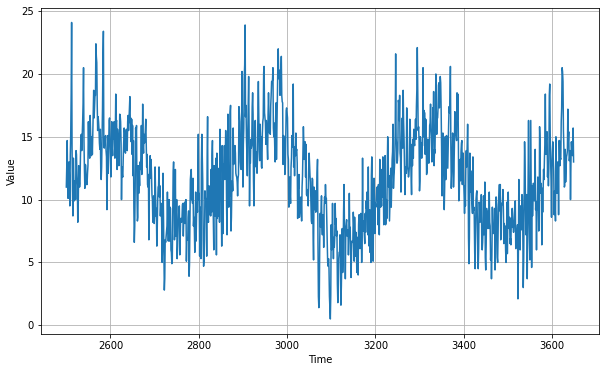

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS